## License Plate Detection Using YoloV8

In [1]:
from ultralytics import YOLO
import cv2
import util
from sort.sort import *
from util import get_car, read_license_plate, write_csv
import torch

torch.cuda.set_device(0) # Set to your desired GPU number

results = {}

mot_tracker = Sort()

# load models
coco_model = YOLO('yolov8n.pt')
license_plate_detector = YOLO('license_plate_detector.pt')

In [4]:
# load video
cap = cv2.VideoCapture('/home/umer/GitHub/lpdr/DSC_0020_clip001.MOV')

vehicles = [2, 3, 5, 7]

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video_path = 'output.mp4'
output_video = cv2.VideoWriter(output_video_path, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

# read frames
frame_nmr = -1
ret = True
while ret:
    frame_nmr += 1
    ret, frame = cap.read()
    if ret:
        results[frame_nmr] = {}
        # detect vehicles
        detections = coco_model(frame)[0]
        detections_ = []
        for detection in detections.boxes.data.tolist():
            x1, y1, x2, y2, score, class_id = detection
            if int(class_id) in vehicles:
                detections_.append([x1, y1, x2, y2, score])

        # track vehicles
        track_ids = mot_tracker.update(np.asarray(detections_))

        # detect license plates
        license_plates = license_plate_detector(frame)[0]
        for license_plate in license_plates.boxes.data.tolist():
            x1, y1, x2, y2, score, class_id = license_plate

            # assign license plate to car
            xcar1, ycar1, xcar2, ycar2, car_id = get_car(license_plate, track_ids)

            if car_id != -1:
                # crop license plate from the original image
                license_plate_crop_original = frame[int(y1):int(y2), int(x1):int(x2), :]

                # process license plate
                # cv2.imshow("Crop License Plate Original", license_plate_crop_original)
                # cv2.waitKey(0)

                # Save the license plate with the same resolution as the original input image
                # output_path = f"pexels_video/license_plate_{frame_nmr}_{car_id}.jpg"
                # cv2.imwrite(output_path, license_plate_crop_original)
                # Write the frame with bounding boxes to the output video
                output_video.write(frame)

# Release everything if job is finished
cap.release()
output_video.release()
cv2.destroyAllWindows()

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'

0: 384x640 5 persons, 2 cars, 2 motorcycles, 1 truck, 186.2ms
Speed: 11.8ms preprocess, 186.2ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 license_plate, 59.9ms
Speed: 4.3ms preprocess, 59.9ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 persons, 1 bicycle, 4 cars, 2 motorcycles, 1 truck, 68.1ms
Speed: 5.1ms preprocess, 68.1ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 license_plate, 61.6ms
Speed: 6.9ms preprocess, 61.6ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 5 persons, 1 bicycle, 2 cars, 2 motorcycles, 1 truck, 69.3ms
Speed: 6.2ms preprocess, 69.3ms inference, 8.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 license_plate, 60.8ms
Speed: 5.6ms preprocess, 60.8m

## Character Segmentation

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

#             Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
    plt.show()
    
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [2]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/10,
                  2*LP_WIDTH/2.5,
                  LP_HEIGHT/15,
                  2*LP_HEIGHT/2.5]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg', img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)
    
    return char_list

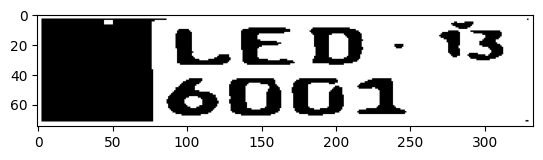

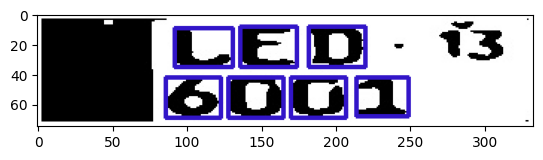

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [3]:
img = cv2.imread('s3.jpg')
# img = cv2.imread('indcar1.jpg')
char = segment_characters(img)
char

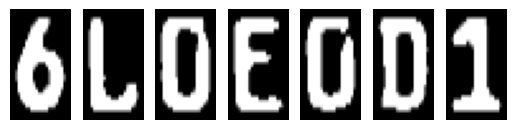

In [4]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

## Model for Characters Recognition

In [5]:
# importing required libraries
import tensorflow as tf
from tensorflow.keras.models import save_model, load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers

2024-01-18 11:00:07.950080: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 11:00:07.950211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 11:00:07.955809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 11:00:07.978892: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 11:00:11.209375: W tensorflow/compiler/tf2

In [21]:
# Loading model architecture
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        'data/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [10]:
# Defining model
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])
model.summary()

2024-01-12 10:44:17.877015: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 10:44:17.971915: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 10:44:17.972122: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 10:44:17.977657: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 10:44:17.977823: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 64)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

In [29]:
# model fitting with early stopping callback to prevent overfitting
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=True):
    # if(logs.get('val_acc') > 0.992):
    val_acc = logs.get('val_acc')
    print(logs)
    if val_acc and val_acc > 0.982:
      self.model.stop_training = True

import datetime
!rm -rf logs
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
batch_size = 1
callbacks = [tensorboard_callback, stop_training_callback()]

model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // batch_size,
      epochs = 80, callbacks=callbacks)

Epoch 1/80
864/864 [==============================] - 26s 30ms/step - loss: 1.2805 - accuracy: 0.6146
Epoch 2/80
864/864 [==============================] - 28s 32ms/step - loss: 1.0808 - accuracy: 0.6887
Epoch 3/80
864/864 [==============================] - 27s 32ms/step - loss: 0.9470 - accuracy: 0.6979
Epoch 4/80
864/864 [==============================] - 33s 38ms/step - loss: 0.8616 - accuracy: 0.7303
Epoch 5/80
864/864 [==============================] - 30s 35ms/step - loss: 0.8163 - accuracy: 0.7350
Epoch 6/80
864/864 [==============================] - 31s 36ms/step - loss: 0.7195 - accuracy: 0.7674
Epoch 7/80
864/864 [==============================] - 34s 39ms/step - loss: 0.6110 - accuracy: 0.8032
Epoch 8/80
864/864 [==============================] - 37s 43ms/step - loss: 0.6306 - accuracy: 0.8067
Epoch 9/80
864/864 [==============================] - 40s 47ms/step - loss: 0.5476 - accuracy: 0.8137
Epoch 10/80
864/864 [==============================] - 47s 54ms/step - loss: 0.502

In [18]:
# !kill 8400
%load_ext tensorboard
%tensorboard --logdir logs/fit

Launching TensorBoard...

In [8]:
# loading trained model from disk
model = load_model('tfkmodel.keras')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 64)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

In [40]:
# evaluate the model
scores = model.evaluate(validation_generator, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 98.15%


In [14]:
# Saving model to disk
save_model(model, "tfkmodel.keras")

## Infer Characters From The Image

In [16]:
# Preprocess input image for character prediction
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img


def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): # iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) # preparing image for the model
        # y_ = model.predict_classes(img)[0] # predicting the class
        predict_x= model.predict(img)
        classes_x = int(np.argmax(predict_x, axis=1)[0])
        character = dic[classes_x] #
        output.append(character) # storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number
lp_number = show_results()
print(lp_number)

1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 41ms/step
6L0EGD1


In [10]:
# Function for sorting characters and numbers
def sortplate(lp):
      nums, chars = [], []
      for c in lp:
        if c.isalpha():
          chars.append(c)
        elif c.isnumeric():
          nums.append(c)
        else:
          print(f"Ignored '{c}' because it's neither alphabet nor numeric.")
      slp = "".join(chars) + " " + "".join(nums)
      return slp

In [13]:
print(f"Detected license plate: {lp_number}") # detected license plate
print(f"Sorted license plate: {sortplate(lp_number)}") # sorted license plate

Detected license plate: 6L0EGD1
Sorted license plate: LEGD 601


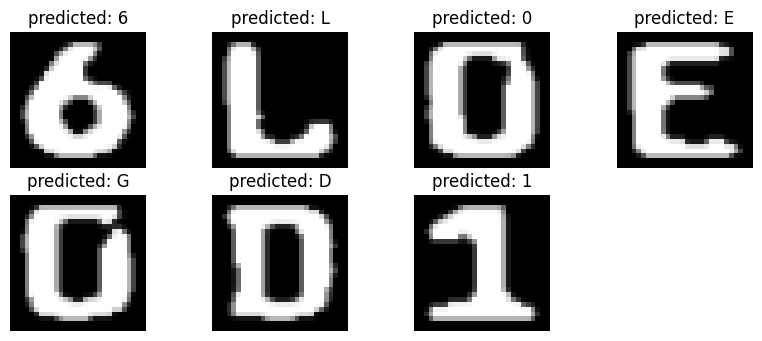

In [12]:
# Displaying segmented and recognized characters along with predicted labels
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {lp_number[i]}')
    plt.axis('off')
plt.show()